# COVID-19 India : Intelligent Resource Predictor

### Finding gap between the requirement of beds for Covid care and their availability in every state's medical facility.

# Flow 
1. Predict the estimated No. of covid cases on a day for a state.
2. Derive the number of cases that require hospitalization out of the total count obtained in the previous step.
3. Find the gap between the figure obtained above and from the recent data of vacanct beds for a state.

# Contents
1. Datasets
2. Data Preparation - Train/test
3. Model Training
4. Predicting the number of COVID cases 7 days from present day
5. Backtesting
6. Model Evaluation
7. Finding No. of patients to be hospitalised
8. Finding Gap in availabity of No. of beds for COVID cases

### Training data -
Data span - 2nd April to 15th May
Using past 30 days' data, predict estimated postive COVID cases for 7th day from a present day.

### Test data -
Using 30 day rolling window of past data from 15th April onwards, predict count of positive cases for 23rd May to 4th June for each state in India.


### Assumptions for deriving requirement of bed resources
The distribution of demographics w.r.t age of positive COVID cases -

Category 1 - 25% - young children 

Category 2 - 45% - Youth/Middle aged

Category 3 - 30% - Senior  Citizens

We include the 1st and 3rd category (65% of total positive cases) as cases that require hospitalization with priority over the 2nd category.

In [1]:
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(2)

import math
from datetime import datetime
import pandas as pd
import time
import warnings
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
import os

from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM,Dropout,Flatten
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/features-covid/statewise_features.csv
/kaggle/input/covid19-in-india/StatewiseTestingDetails.csv
/kaggle/input/covid19-in-india/covid_19_india.csv
/kaggle/input/covid19-in-india/HospitalBedsIndia.csv
/kaggle/input/covid19-in-india/IndividualDetails.csv
/kaggle/input/covid19-in-india/AgeGroupDetails.csv
/kaggle/input/covid19-in-india/ICMRTestingLabs.csv
/kaggle/input/covid19-in-india/population_india_census2011.csv
/kaggle/input/district-containment-zones/district-containment-zones-2020-04-30.csv


Features in the dataset below are at daily level derived from the COVID19 dataset containing cumulative statewise counts of new, recovered & deceased cases.


In [3]:
covid_features = pd.read_csv("/kaggle/input/features-covid/statewise_features.csv")
beds_dataset = pd.read_csv("/kaggle/input/covid19-in-india/HospitalBedsIndia.csv", index_col=0)
containment_zones = pd.read_csv("/kaggle/input/district-containment-zones/district-containment-zones-2020-04-30.csv")

In [4]:
covid_features.head()

,Date,State,pop_density,new_cases,samples_tested
0,2020-04-24,Andaman and Nicobar Islands,46.0,15.0,1276.0
1,2020-04-27,Andaman and Nicobar Islands,46.0,6.0,169.0
2,2020-05-01,Andaman and Nicobar Islands,46.0,0.0,906.0
3,2020-05-16,Andaman and Nicobar Islands,46.0,0.0,2923.0
4,2020-05-22,Andaman and Nicobar Islands,46.0,0.0,586.0


In [5]:
covid_features['Date'] = pd.to_datetime(covid_features['Date'], format="%Y-%m-%d")

covid_features['Date'].min(), covid_features['Date'].max()

(Timestamp('2020-04-02 00:00:00'), Timestamp('2020-06-04 00:00:00'))

In [6]:
covid_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1679 non-null   datetime64[ns]
 1   State           1679 non-null   object        
 2   pop_density     1679 non-null   float64       
 3   new_cases       1679 non-null   float64       
 4   samples_tested  1679 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 65.7+ KB


In [7]:
covid_features['State'].nunique()

35

In [8]:
# No. of steps for LSTM to look back for making predictions

timesteps = 30

# Data Preparation

In [9]:
def transformDF(df,state,date_start,date_end,date_col="Date"):
    # fetch selective columns
    df_columns = ["State",date_col,"scaled_pop_density","new_cases","samples_tested"]
    df = df[df_columns]
    state_df = df[df['State'] == state]
    state_df[date_col] = pd.to_datetime(state_df[date_col])
    # Generate valid dates in the specified data range
    all_dates_df = pd.DataFrame(pd.date_range(start=date_start,end=date_end,freq='D'),columns=['date'])
    all_days_state_df = all_dates_df.merge(state_df,
                                                how='left',
                                                left_on='date',
                                                right_on=date_col)
    pop_density = all_days_state_df[~all_days_state_df['scaled_pop_density'].isnull()]["scaled_pop_density"].unique()[0]
    values = {"State":state,
             "new_cases":0,
             "samples_tested":0,
             "scaled_pop_density":pop_density}
    final_df = all_days_state_df.fillna(value=values)\
                               .drop(date_col,axis=1)
    return final_df

In [10]:
def getPreparedData(timesteps,df):
    # Preparing the data
    input_data = []              # historic input values 
    actual_data = []             # actual values at current time instance as target values
    scalers = []  
    N_STEPS = timesteps          # No. of timesteps back in time that the LSTM model sees
    # df = df[['pop_density','new_cases','samples_tested']]
    df = df[['scaled_pop_density','new_cases','samples_tested']]
    lookahead_day = 7            # The Nth day in future for which to make prediction
    nfeatures = len(df.columns)
    
    feature_index = 1            #  index of feature - new_cases
    ## At each prediction timestep, we provide values from n_steps historical timesteps
    for i in range(N_STEPS,len(df) - lookahead_day):  
        historical_x_val = df.values[i-N_STEPS:i]
        y_val = df.values[i+lookahead_day][feature_index]
        minmax_scaler = MinMaxScaler(feature_range=(0,1))
        scaled_x = historical_x_val[:]   
        
        # 1st feature is scaled already. Skipping this feature in scaling step below
        scaled_x[:,1:] = minmax_scaler.fit_transform(historical_x_val[:,1:])     
        
        # Scaling target values
        scaling_shape = (1, nfeatures - 1)                        # subtract 1 from num features scaled
        reshaped_y = np.broadcast_to(y_val,scaling_shape)         # Make its shape compatible for minmax scale transformation
        scaled_y = max(0, minmax_scaler.transform(reshaped_y)[0][0])
    
        input_data.append(scaled_x) 
        actual_data.append(scaled_y)
        scalers.append(minmax_scaler)
    train_x = np.array(input_data)
    train_y = np.array(actual_data)
    assert len(train_x.shape) == 3 , "x_train is expected to be 3-Dimensional for LSTM"
    return train_x,train_y,scalers



### Training data

In [11]:
# Scaling population density using data from all states
density_scaler = MinMaxScaler((0,1))
covid_features['scaled_pop_density'] = density_scaler.fit_transform(covid_features['pop_density'].values.reshape(-1,1))

In [12]:
# Use data from 1st April to 15th May for training
# Combining data from multiple state to prepare training dataset 30 days long

start_time = time.time()
trainX = trainY = TrainScalers = None

for i,state in enumerate(covid_features['State'].unique()):
    state_df = transformDF(covid_features,state,date_start='2020-04-02',date_end='2020-05-15',date_col="Date")
    # print(state_df)
    train_x,train_y,train_scaler = getPreparedData(timesteps=timesteps\
                                                 ,df=state_df)
    
    if trainX is None:
            trainX = train_x
            trainY = train_y
            TrainScalers = train_scaler

    else:
        trainX = np.vstack((trainX,train_x))
        trainY = np.hstack((trainY,train_y))
        TrainScalers = TrainScalers + train_scaler

print("Training data prepared in {} seconds".format(time.time() - start_time))

Training data prepared in 0.5007898807525635 seconds


In [13]:
trainX.shape, trainY.shape, len(TrainScalers)

((245, 30, 3), (245,), 245)

### Testing data

In [14]:
# Use data from 1st April to 15th May for training
# Combining data from multiple states to prepare training dataset 30 days long

nrecords = 13   # No. of test data points per state
start_time = time.time()
testX  = testY = testScalers = testStateDf = target_y = None

for i,state in enumerate(covid_features['State'].unique()):
    state_df = transformDF(covid_features,state,date_start='2020-04-15',date_end='2020-06-03',date_col="Date")
    
    test_X,test_Y,test_scalers = getPreparedData(timesteps=timesteps\
                                                 ,df=state_df)
    target_Y = state_df['new_cases'].values[-nrecords: ]
    if testX is None:
        testX = test_X
        testY = test_Y
        testScalers = test_scalers 
        target_y = target_Y
    else:
        testX = np.vstack((testX,test_X))
        testY = np.hstack((testY,test_Y))
        testScalers = testScalers + test_scalers
        testStateDf = pd.concat([testStateDf,state_df])
        target_y = np.hstack((target_y,target_Y))
        
print("Test data prepared in {} seconds".format(time.time() - start_time))

Test data prepared in 0.5779397487640381 seconds


With data span from 15th April to 14th May, considering 30 back time steps, and to predict for 7th day from 15th May onwards,we will test predictions from 23rd May to 4th June. This way, we have 13 test data points for each of the 35 states.

# Model training

In [15]:
bs = 16
epoch = 400
lr = 0.001
lstm_dropout = 0.2
lstm_nodes = 8
optimizer = keras.optimizers.Adam(learning_rate=lr)
num_features = 3     # no. of positive cases, total samples tested on a day & population density of state
training_loss = tf.keras.losses.MAE

checkpoint_path = "./covid_adam_tanh_relu_checkpoint"
logdir = "./logs/covid_adam_tanh_relu" + datetime.now().strftime(format="&Y%m%d-%H-%M-%S")

# for visualizing training metrics on tensorboard
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,update_freq='epoch')
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        verbose=2,
                                                        period=20,
                                                        save_best_only=True)

In [16]:
## Setting up the forecasting model using LSTM
model = Sequential()
model.add(LSTM(units=lstm_nodes, input_shape=(timesteps, num_features), return_sequences=True,dropout=0.0))
model.add(LSTM(units=lstm_nodes, return_sequences=False,dropout=0.0))
model.add(Dropout(rate=lstm_dropout))
model.add(Dense(units=20,activation='tanh',name="dense_1"))
model.add(Dense(units=1,activation='relu',name="dense_2_output"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                180       
_________________________________________________________________
dense_2_output (Dense)       (None, 1)                 21        
Total params: 1,129
Trainable params: 1,129
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=optimizer,loss=training_loss,metrics=['mae','mse'])

In [18]:
%time history = model.fit(x=trainX\
                        ,y=trainY\
                        ,batch_size=bs\
                        ,epochs=epoch\
                        ,verbose=2\
                        ,callbacks=[tensorboard_callback,checkpoint_callback]\
                        ,shuffle=True)

Train on 245 samples
Epoch 1/400
245/245 - 4s - loss: 2.7215 - mae: 2.7215 - mse: 155.9187
Epoch 2/400
245/245 - 1s - loss: 2.6903 - mae: 2.6903 - mse: 155.2086
Epoch 3/400
245/245 - 1s - loss: 2.6711 - mae: 2.6711 - mse: 154.4348
Epoch 4/400
245/245 - 1s - loss: 2.6640 - mae: 2.6640 - mse: 153.9490
Epoch 5/400
245/245 - 1s - loss: 2.6707 - mae: 2.6707 - mse: 153.4798
Epoch 6/400
245/245 - 0s - loss: 2.6603 - mae: 2.6603 - mse: 153.3840
Epoch 7/400
245/245 - 0s - loss: 2.6497 - mae: 2.6497 - mse: 153.5809
Epoch 8/400
245/245 - 0s - loss: 2.6519 - mae: 2.6519 - mse: 153.4725
Epoch 9/400
245/245 - 0s - loss: 2.6401 - mae: 2.6401 - mse: 153.1078
Epoch 10/400
245/245 - 0s - loss: 2.6382 - mae: 2.6382 - mse: 153.2156
Epoch 11/400
245/245 - 0s - loss: 2.6185 - mae: 2.6185 - mse: 152.7534
Epoch 12/400
245/245 - 0s - loss: 2.6292 - mae: 2.6292 - mse: 152.8460
Epoch 13/400
245/245 - 0s - loss: 2.6133 - mae: 2.6133 - mse: 153.4318
Epoch 14/400
245/245 - 0s - loss: 2.5926 - mae: 2.5926 - mse: 153

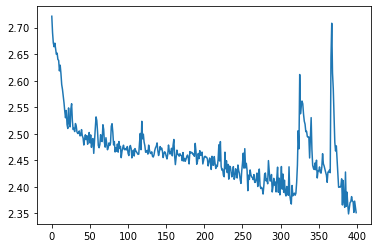

In [19]:
# Plotting loss function during training phase

plt.plot(history.history['loss'])
plt.show()

# Predicting the number of COVID cases 7 days from present day

In [20]:
training_orginal_scaled_predictions = []
training_predictions = model.predict(trainX,batch_size=bs)

# Making shape compatible for scaling back into original range
train_size = trainX.shape[0]
reshaped_tr_predictions = np.broadcast_to(training_predictions, (train_size, num_features - 1))
reshaped_tr_predictions[:10]

# scaling the predictions back to orginal scale
for i in range(len(trainX)):
    training_inverse_scaled_predictions = TrainScalers[i].inverse_transform(reshaped_tr_predictions[i].reshape(1,-1))[:,0]
    training_orginal_scaled_predictions.append(training_inverse_scaled_predictions)

# Backtesting

In [21]:
test_inverse_scaled_predictions = []
test_original_scaled_predictions = []

test_predictions = model.predict(testX, batch_size=bs)

test_size = testX.shape[0]
reshaped_test_predictions = np.broadcast_to(test_predictions, (test_size, num_features - 1 ))

# scaling the predictions back to orginal scale
for i in range(len(testScalers)):
    prediction = testScalers[i].inverse_transform(reshaped_test_predictions[i].reshape(1,-1))[:,0]
    test_original_scaled_predictions.append(prediction)


### Rounding off the actual and predicted values upto 3 decimal places

In [22]:
target_y = np.round(target_y,0)
predictions_all_states = np.round(test_original_scaled_predictions,0)
predictions_all_states[predictions_all_states < 0] = 0.0

In [23]:
# List of dates for which the predictions are made

dates = covid_features.sort_values('Date')['Date'].astype(str).unique()[-nrecords:].tolist()

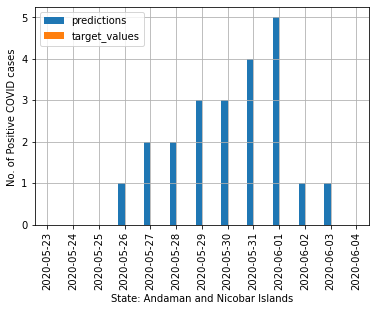

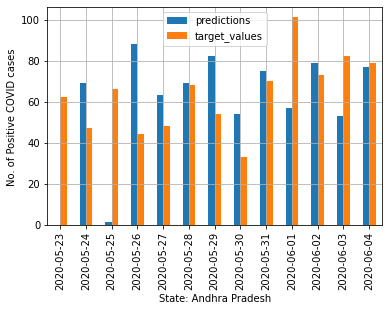

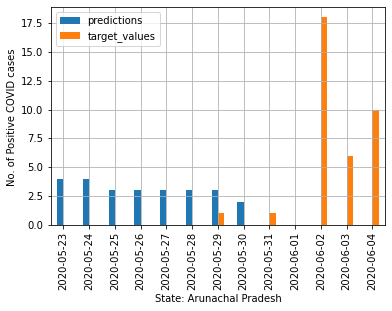

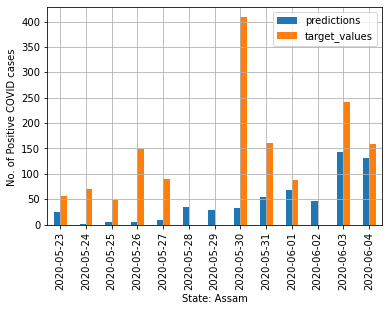

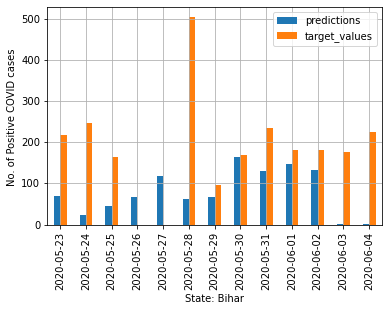

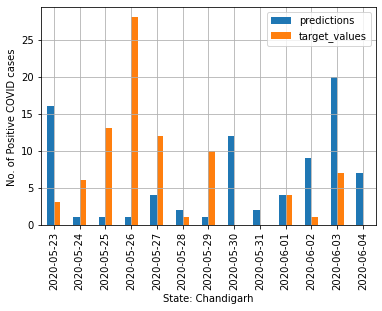

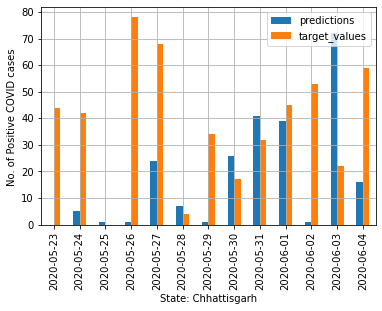

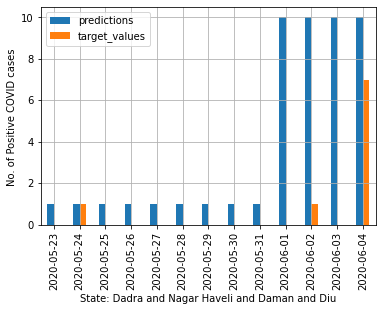

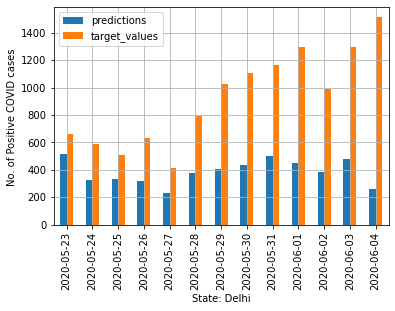

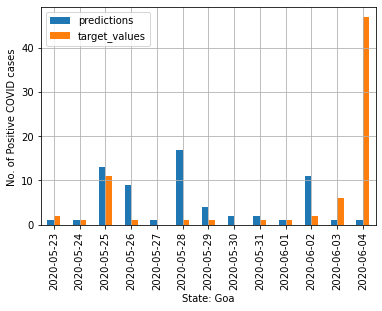

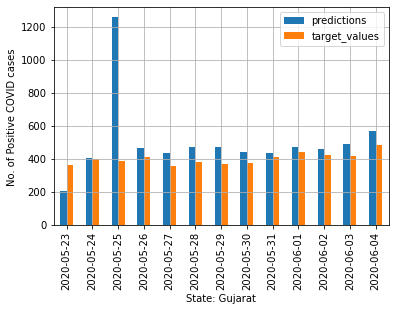

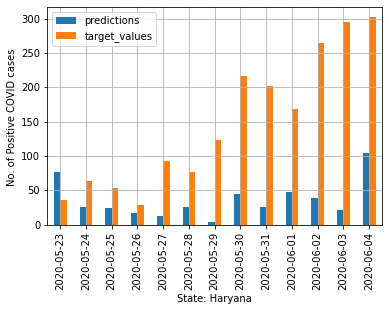

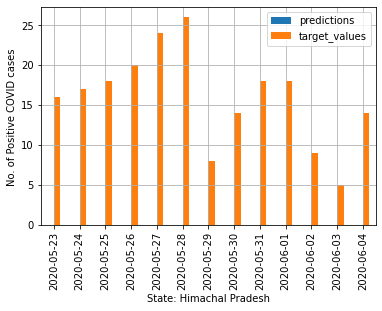

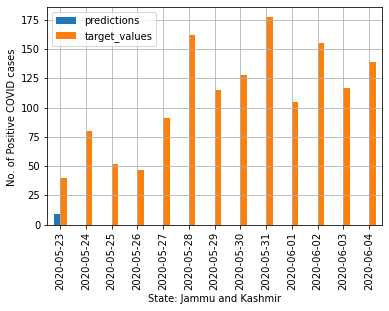

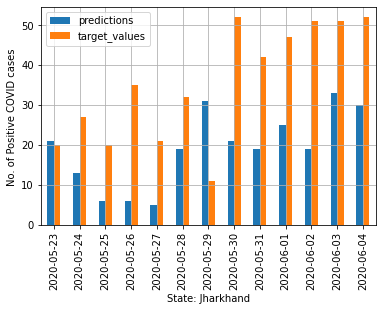

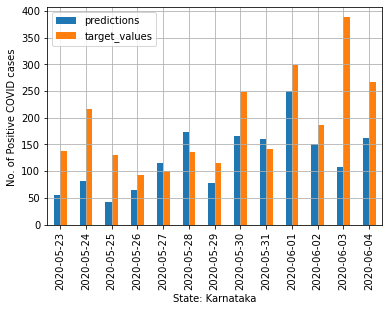

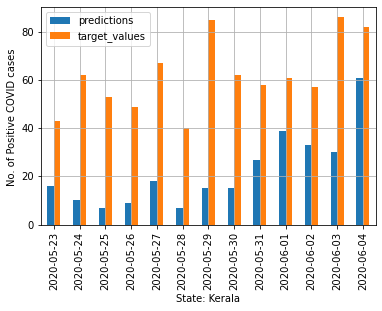

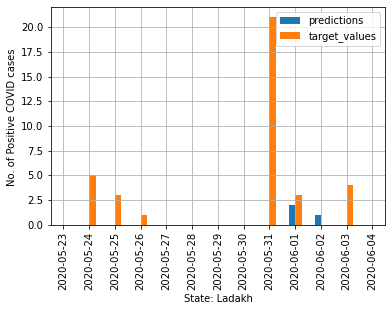

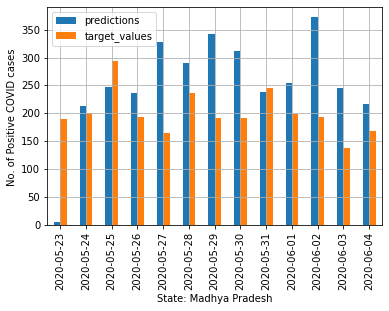

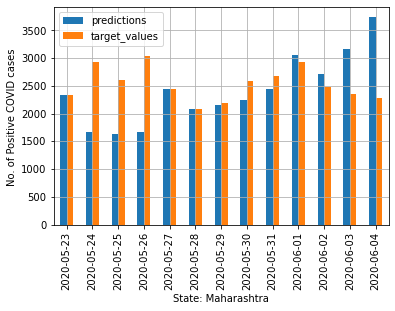

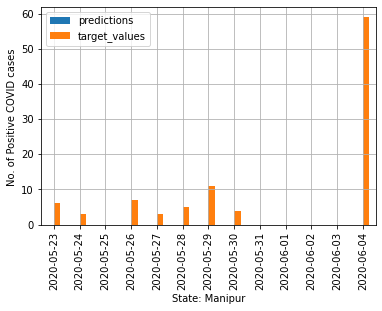

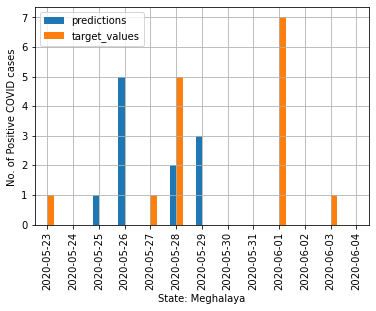

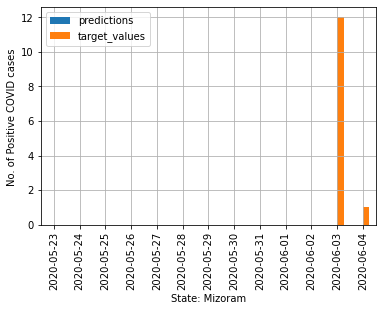

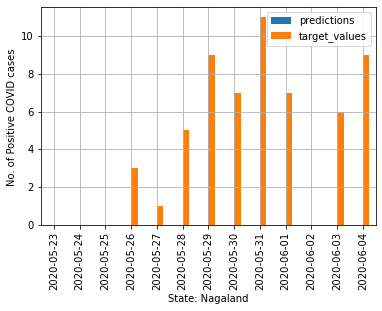

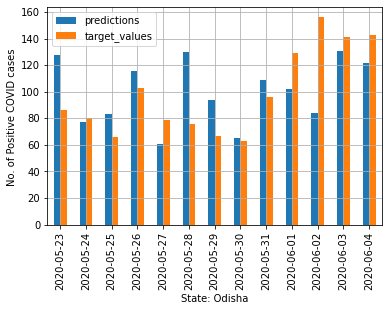

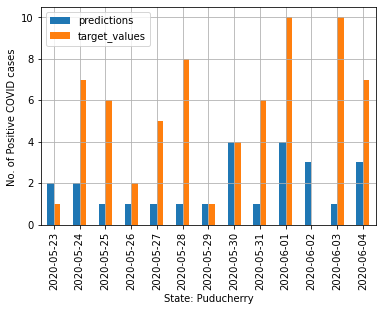

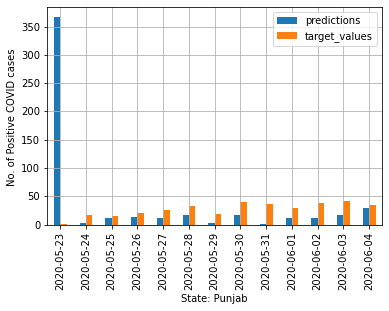

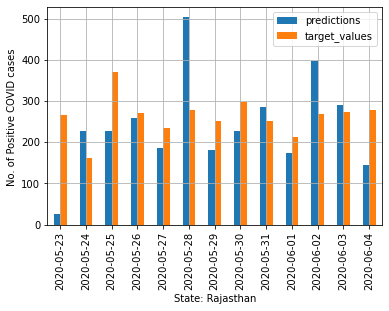

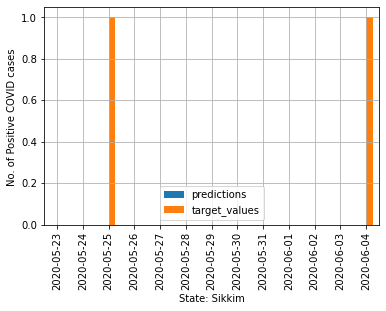

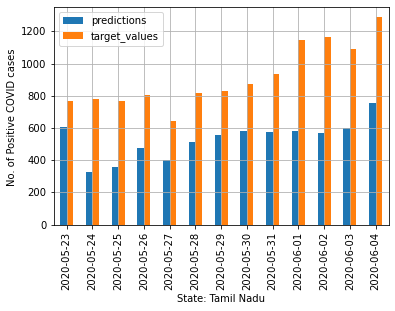

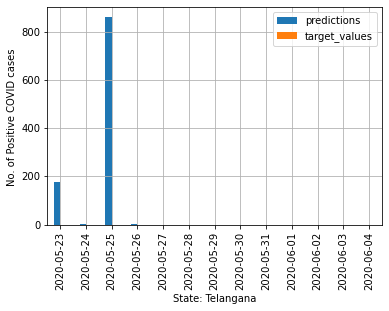

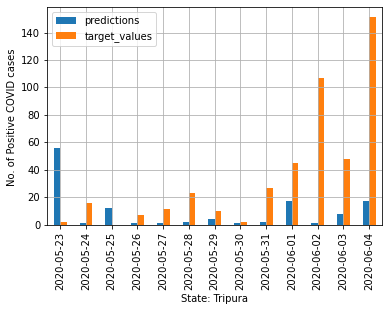

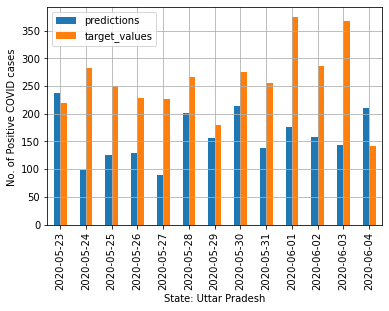

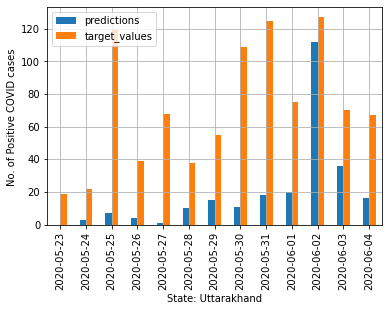

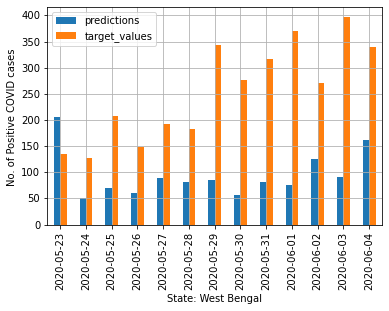

In [24]:
predictions_df = None

index = 0
states = covid_features['State'].unique()
for i in range(0,len(testScalers),nrecords):
    test_state_df = pd.DataFrame(predictions_all_states[i:i+nrecords], columns=['predictions'])
    test_state_df['State'] = states[index]
    test_state_df['Date'] = dates
    test_state_df['target_values'] = target_y[i:i+nrecords]
    test_state_df[["predictions","target_values"]].plot(kind='bar',figsize=(6,4),grid=True)
    plt.xlabel("State: {}".format(states[index]))
    plt.ylabel("No. of Positive COVID cases ")
    plt.xticks(range(nrecords),dates)
    index += 1
    predictions_df = pd.concat([predictions_df,test_state_df])
    plt.show()

High deviation between model predictions and actual count of confirmed cases from above visualizations for states Nagaland, Punjaba and Andaman and Nicobar Islands can be justified by the past trend of counts in these states

In [25]:
covid_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1679 non-null   datetime64[ns]
 1   State               1679 non-null   object        
 2   pop_density         1679 non-null   float64       
 3   new_cases           1679 non-null   float64       
 4   samples_tested      1679 non-null   float64       
 5   scaled_pop_density  1679 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 78.8+ KB


In [26]:
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'], format="%Y-%m-%d")


In [27]:
# Combining predictions with original features

covid_features['Date'] = covid_features.Date.astype(str)
predictions_df['Date'] = predictions_df.Date.astype(str)
features_with_predictions = covid_features.merge(predictions_df[['predictions','Date','State']], 
                     how='left', 
                    on=['Date','State'])
features_with_predictions.drop("scaled_pop_density", axis=1, inplace=True)

<Figure size 720x288 with 0 Axes>

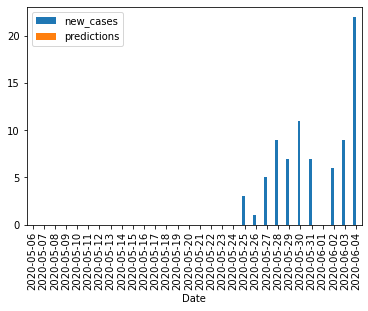

In [28]:
state = "Nagaland"
plt.figure(figsize=(10,4))
features_with_predictions[features_with_predictions['State']==state].set_index('Date')[['new_cases','predictions']][-30:].plot(kind="bar")
plt.show()

<Figure size 720x288 with 0 Axes>

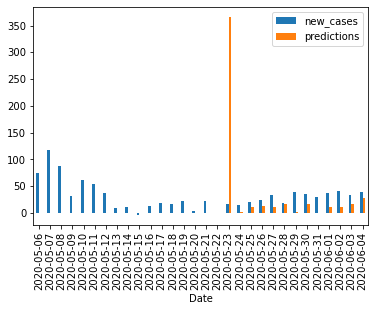

In [29]:
state = "Punjab"
plt.figure(figsize=(10,4))
features_with_predictions[features_with_predictions['State']==state].set_index('Date')[['new_cases','predictions']][-30:].plot(kind="bar")
plt.show()

<Figure size 720x288 with 0 Axes>

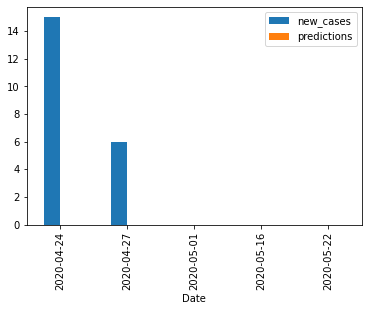

In [30]:
state = "Andaman and Nicobar Islands"
plt.figure(figsize=(10,4))
features_with_predictions[features_with_predictions['State']==state].set_index('Date')[['new_cases','predictions']][-30:].plot(kind="bar")
plt.show()

# Model Evaluation 

In [31]:
# Mean absolute error

mae = mean_absolute_error(target_y, predictions_all_states)
mae

85.21978021978022

In [32]:
# Mean squared error
mse = mean_squared_error(target_y, predictions_all_states)
rmse = math.sqrt(mse)
rmse


202.7312029741368

# Number of patients to be hospitalized

Assuming 65% of the predicted positive cases require hospitalization. This group of patients may belong to the population of senior citizens or poeple with pre-morbid health conditions.
Then the total number of hospitalizations that is expected to be done is - 

In [33]:
statewise_hosp_requirement = predictions_df[['Date','State','predictions']]
statewise_hosp_requirement.columns = ['Date', 'State', 'predicted_case_count']
statewise_hosp_requirement['num_hosp_required'] = np.round(statewise_hosp_requirement['predicted_case_count']*0.65, 0)

In [34]:
statewise_hosp_requirement = statewise_hosp_requirement.groupby('State').sum().reset_index()

In [35]:
statewise_hosp_requirement.head()

,State,predicted_case_count,num_hosp_required
0,Andaman and Nicobar Islands,22.0,15.0
1,Andhra Pradesh,767.0,498.0
2,Arunachal Pradesh,25.0,17.0
3,Assam,584.0,380.0
4,Bihar,1023.0,667.0


# Gap in availabity of No. of beds for COVID cases

In [36]:
beds_dataset.head()

,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
Sno,,,,,,,,,,,
1,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
2,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658
3,Arunachal Pradesh,122,62,NaN,15,199,2320,208,2136,10,268
4,Assam,1007,166,14.0,33,1220,19115,1176,10944,50,6198
5,Bihar,2007,63,33.0,43,2146,17796,930,6083,103,5936


In [37]:
# Assuming 5% of total Beds are reserved for COVID care
# Assuming only 2% of those beds are vacant for hospitalizing newly diagnozed patients
# The available bed count is - 

beds_dataset['total_beds'] = beds_dataset['NumPublicBeds_HMIS'] + beds_dataset['NumRuralBeds_NHP18'] + beds_dataset['NumUrbanBeds_NHP18']
beds_dataset['beds_for_covid'] = np.round(beds_dataset['total_beds']*0.05, 0)
# beds_dataset['vacant_beds_for_covid'] = np.round(beds_dataset['beds_for_covid']*0.02, 0)

In [38]:
covid_beds_data = beds_dataset[['State/UT','beds_for_covid']]

In [39]:
# Data cleaning for consistent data before joining

covid_beds_data['State/UT'] = covid_beds_data['State/UT'].str.replace('&', 'and')
covid_beds_data.loc[covid_beds_data['State/UT'].str.contains('Diu'), 'State/UT'] = "Dadra and Nagar Haveli and Daman and Diu"
covid_beds_data.loc[covid_beds_data['State/UT'].str.contains('Dadra'), 'State/UT'] = "Dadra and Nagar Haveli and Daman and Diu"

In [40]:
covid_beds_data = covid_beds_data.groupby('State/UT').sum().reset_index()
covid_beds_data.columns = ['State', 'beds_for_covid']

### Merging the details of requirements per state and available hospital beds

In [41]:
statewise_avail_req = statewise_hosp_requirement.merge(covid_beds_data, 
                                on='State',
                                how='left')

In [42]:
statewise_avail_req.tail()

,State,predicted_case_count,num_hosp_required,beds_for_covid
30,Telangana,1040.0,677.0,1917.0
31,Tripura,123.0,81.0,466.0
32,Uttar Pradesh,2081.0,1353.0,6728.0
33,Uttarakhand,253.0,165.0,759.0
34,West Bengal,1234.0,801.0,6486.0


For 13 days of span, the difference between the beds availaible for COVID and total No. of hospitalizations required will give us the gap in bed resource. A positive value of the difference denotes the shortage of the resource.

In [43]:
statewise_avail_req['gap_in_req_beds'] = statewise_avail_req['num_hosp_required'] - statewise_avail_req['beds_for_covid']


## Top 4 states falling short of bed resources

In [44]:
statewise_avail_req.sort_values('gap_in_req_beds', ascending=False).head(4)

,State,predicted_case_count,num_hosp_required,beds_for_covid,gap_in_req_beds
19,Maharashtra,31388.0,20401.0,6022.0,14379.0
8,Delhi,5009.0,3255.0,2248.0,1007.0
10,Gujarat,6575.0,4274.0,3670.0,604.0
7,Dadra and Nagar Haveli and Daman and Diu,49.0,33.0,85.0,-52.0
